In [1]:
import numpy as np
import os
import pandas as pd
from glob import glob
# from multiprocessing import Process, Pool, Manager, cpu_count
# from ipywidgets import IntProgress as Progress, Layout
import time

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100

import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("mol.csv")
df

,molecule_name,atom_index,atom,x,y,z
0,mol_1,0,O,1.1229,0.1995,-0.4546
1,mol_1,1,O,2.4378,0.4571,0.1075
2,mol_1,2,O,-1.4723,1.2002,0.1915
3,mol_1,3,C,-0.8476,-1.1292,-0.1122
4,mol_1,4,C,0.5434,-0.7848,0.3922
...,...,...,...,...,...,...
114,mol_10,8,O,0.2275,-1.6499,0.3651
115,mol_10,9,H,0.9276,-2.3165,0.3880
116,mol_10,10,O,-2.3505,1.2041,0.1417
117,mol_10,11,H,10.9073,3.3679,1.1083


In [3]:
# define bond length of element for single bond, double bond, and triple bond
bond_lengths = {'H': np.array([0.32, np.NaN, np.NaN]),
                'C': np.array([.75, .67, .60]),
                'O': np.array([.63, .57, .54]),
                'N': np.array([.71, .60, .54]),
                'F': np.array([.64, .59, .53])}

In [4]:
df['radii'] = [bond_lengths[a] for a in df.atom]
df

,molecule_name,atom_index,atom,x,y,z,radii
0,mol_1,0,O,1.1229,0.1995,-0.4546,"[0.63, 0.57, 0.54]"
1,mol_1,1,O,2.4378,0.4571,0.1075,"[0.63, 0.57, 0.54]"
2,mol_1,2,O,-1.4723,1.2002,0.1915,"[0.63, 0.57, 0.54]"
3,mol_1,3,C,-0.8476,-1.1292,-0.1122,"[0.75, 0.67, 0.6]"
4,mol_1,4,C,0.5434,-0.7848,0.3922,"[0.75, 0.67, 0.6]"
...,...,...,...,...,...,...,...
114,mol_10,8,O,0.2275,-1.6499,0.3651,"[0.63, 0.57, 0.54]"
115,mol_10,9,H,0.9276,-2.3165,0.3880,"[0.32, nan, nan]"
116,mol_10,10,O,-2.3505,1.2041,0.1417,"[0.63, 0.57, 0.54]"
117,mol_10,11,H,10.9073,3.3679,1.1083,"[0.32, nan, nan]"


In [5]:
def get_structure(molecule_name):
    return df[df['molecule_name'] == molecule_name]

In [6]:
def get_structure_x(structure):
    positions = structure[['x', 'y', 'z']].values
    structure_X = pd.merge(structure, structure, how='outer', on=['molecule_name'])
    structure_X['distance'] = np.linalg.norm(structure_X[['x_x', 'y_x', 'z_x']].values - structure_X[['x_y', 'y_y', 'z_y']].values, axis=1)
    structure_X = structure_X[(structure_X.atom_index_x > structure_X.atom_index_y)]
    structure_X['cutoff'] = (structure_X.distance - (structure_X.radii_x + structure_X.radii_y)).apply(abs).apply(min)
    structure_X.sort_values('cutoff', inplace=True)
    return structure_X

In [7]:
def get_graph(structure, cutoff=0.2):
    structure_x = get_structure_x(structure)
    structure_x = structure_x[~((structure_x.atom_x == 'H') & 
                                (structure_x.atom_y == 'H'))]
    g = nx.Graph()
    positions = structure[['x', 'y', 'z']].values
    g.add_nodes_from(structure['atom_index'], pos=positions)
    
    cols = ['atom_index_x', 'atom_index_y', 'distance', 'cutoff']
    X = [ tuple(i) for i in structure_x[cols].values ]
    
    for i_a, i_b, d, c in X:
        if c < cutoff:
            g.add_edge(i_a, i_b, length=d)
        elif nx.number_connected_components(g) == 1:
            break
        else:
            g.add_edge(i_a, i_b, length=d)
    return g

Find relation in the graph (optional)

In [8]:
def cosinus(x0, x1, x2):
    e0 = (x0-x1)
    e1 = (x2-x1)
    e0 = (e0 / np.linalg.norm(e0))
    e1 = (e1 / np.linalg.norm(e1))
    cosinus = np.dot(e0, e1)
    return np.round(cosinus, 5)


def dihedral(x0, x1, x2, x3):

    b0 = -1.0 * (x1 - x0)
    b1 = x2 - x1
    b2 = x3 - x2

    b0xb1 = np.cross(b0, b1)
    b1xb2 = np.cross(b2, b1)

    b0xb1_x_b1xb2 = np.cross(b0xb1, b1xb2)

    y = np.dot(b0xb1_x_b1xb2, b1)*(1.0/np.linalg.norm(b1))
    x = np.dot(b0xb1, b1xb2)
    
    grad = np.arctan2(y, x)
    return grad

def get_relations(structure, g, atom_index_0, atom_index_1):

    shortest_path = nx.shortest_path(g, atom_index_0, atom_index_1)
    shortest_path_atoms = ''.join([structure[structure.atom_index == i].atom.values[0] for i in shortest_path[1:-1]])
    shortest_path_n_bonds = len(shortest_path)-1
    
    cos = None
    dihe = None
    
    if shortest_path_n_bonds == 2:
        x0 = structure[structure.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        x1 = structure[structure.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        x2 = structure[structure.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        cos = cosinus(x0, x1, x2)
        
    if shortest_path_n_bonds == 3:
        x0 = structure[structure.atom_index == shortest_path[0]][['x', 'y', 'z']].values[0]
        x1 = structure[structure.atom_index == shortest_path[1]][['x', 'y', 'z']].values[0]
        x2 = structure[structure.atom_index == shortest_path[2]][['x', 'y', 'z']].values[0]
        x3 = structure[structure.atom_index == shortest_path[3]][['x', 'y', 'z']].values[0]
        dihe = dihedral(x0, x1, x2, x3)
        
    results = {
        'molecule_name': structure.molecule_name.values[0],
        'atom_index_0': atom_index_0,
        'atom_index_1': atom_index_1,
        'shortest_path_atoms': shortest_path_atoms,
        'shortest_path_n_bonds': shortest_path_n_bonds,
        'cosinus': cos,
        'dihedral': dihe
               }
    
    return pd.DataFrame(results, index=[0])

Single plot

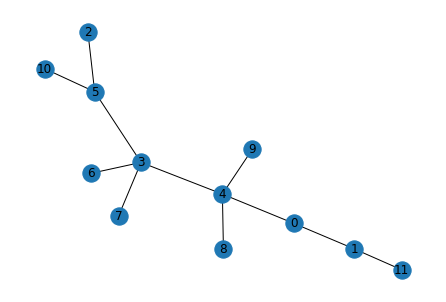

In [9]:
structure = get_structure('mol_1')
g = get_graph(structure)
# display(get_relations(structure, g, 3, 6))
# pos = nx.get_node_attributes(g,'pos')
nx.draw(g,
        # pos, 
        with_labels=True
       )

Multiple plots

In [10]:
all_structures = list(df['molecule_name'].unique())

In [11]:
df['atom_code'] = pd.Categorical(df['atom'])
df['atom_code'] = df['atom_code'].cat.codes

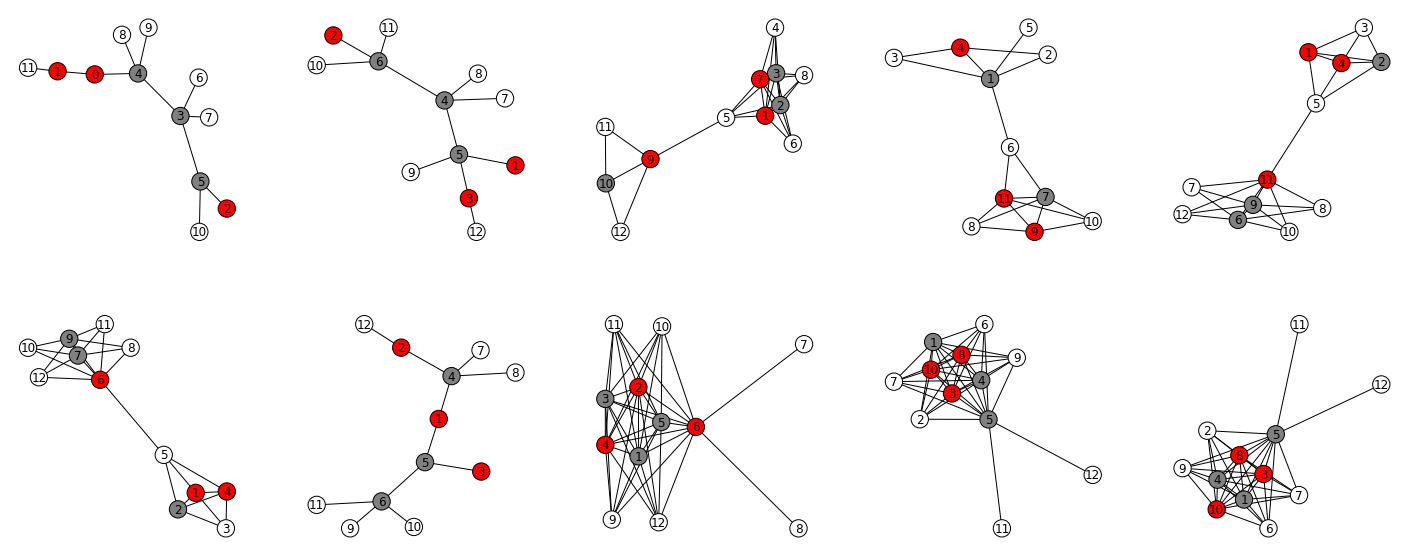

In [12]:
plt.figure(figsize=(25, 10))

# 0 = Carbon = grey
# 1 = Hydrogen = blue
# 2 = Oxygen = red
cmap = matplotlib.colors.ListedColormap(['grey', 'white', 'red'])

for i, name in enumerate(all_structures):
    plt.subplot(2, 5, i+1)
    
    structure = get_structure(name)
    g = get_graph(structure)
    # display(get_relations(structure, g, 3, 6))
    nx.draw_spring(g, 
                   with_labels=True, 
                   node_color=df[df['molecule_name'] == name]['atom_code'], 
                   cmap=cmap,
                   linewidths=1
                  )
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("black")
    
# plt.show()